In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
m = 1.0
k = 1.0
b = 0

In [4]:
# Create a simple PINN model, similar to a Hamiltonian neural network
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Tanh()

    def forward(self, p, q):
        x = torch.cat((p, q), dim=-1)  # Concatenate p and q
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

In [5]:
# Generator function for creating uniformly sampled data in the (q, p) space from (q_min, q_max) and (p_min, p_max), convert to meshgrid
def generate_uniform_data(q_min, q_max, p_min, p_max, num_samples):
    q_lin = torch.linspace(q_min, q_max, num_samples)
    p_lin = torch.linspace(p_min, p_max, num_samples)
    P, Q = torch.meshgrid(p_lin, q_lin, indexing='ij')
    P = P.reshape(-1,1).to(device).requires_grad_(True)
    Q = Q.reshape(-1,1).to(device).requires_grad_(True)
    return P, Q

p, q = generate_uniform_data(-torch.pi/2, torch.pi/2, -2, 2, 50)


In [6]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [7]:
model = PINN(input_dim=2, hidden_dim=64, output_dim=1).to(device)
model.apply(init_weights)
optimizer = optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')

In [8]:
def closure():
    optimizer.zero_grad()
    H = model(p, q)  # shape [2500,1]
    # compute gradients of H wrt p and q
    dH_dp, dH_dq = torch.autograd.grad(
        outputs=H,
        inputs=(p, q),
        grad_outputs=torch.ones_like(H),
        create_graph=True
    )
    # two physics losses
    loss_mom   = torch.mean((m * dH_dp - p)**2)
    loss_force = torch.mean((dH_dq - (k * q))**2)
    dqdt = dH_dp
    dpdt = -dH_dq
    dH_dt = dH_dq * dqdt + dH_dp * dpdt
    loss_cons  = torch.mean(dH_dt**2)

    loss = loss_mom + loss_force + loss_cons
    loss.backward()
    return loss


In [9]:
loss_track = []

progress_bar = tqdm(range(500))

for i in progress_bar:
    optimizer.step(closure)
    loss = closure().item()
    loss_track.append(loss)
    progress_bar.set_postfix({"Loss": f"{loss:.6f}"})

    

  0%|          | 0/500 [00:00<?, ?it/s]/home/ubuntu/ndf-test/.ndf/lib/python3.12/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 500/500 [00:09<00:00, 52.28it/s, Loss=0.000001]


In [10]:
# after training, make sure p and q still have requires_grad=True
p.requires_grad_(True)
q.requires_grad_(True)

# forward pass with grad enabled so autograd can compute partials
H_final = model(p, q)                         # shape [2500,1]
dH_dp, dH_dq = torch.autograd.grad(
    outputs=H_final,
    inputs=(p, q),
    grad_outputs=torch.ones_like(H_final),
    create_graph=False
)

# now compute mean-squared residuals
mom_mse   = torch.mean((m * dH_dp - p)**2).item()
force_mse = torch.mean((dH_dq - k * q)**2).item()

print(f"momentum MSE: {mom_mse:.3e}")
print(f"force    MSE: {force_mse:.3e}")

momentum MSE: 3.180e-07
force    MSE: 2.946e-07


In [11]:
model.eval()

def derivatives(state):
    q_val, p_val = state
    q = torch.tensor([[q_val]], dtype=torch.float32, requires_grad=True, device=device)
    p = torch.tensor([[p_val]], dtype=torch.float32, requires_grad=True, device=device)
    
    # compute Hamiltonian and its gradients
    H = model(p, q)
    dH_dp, dH_dq = torch.autograd.grad(
        outputs=H,
        inputs=(p, q),
        grad_outputs=torch.ones_like(H),
        create_graph=False
    )
    
    dqdt = dH_dp.item()
    dpdt = -dH_dq.item()
    return np.array([dqdt, dpdt])



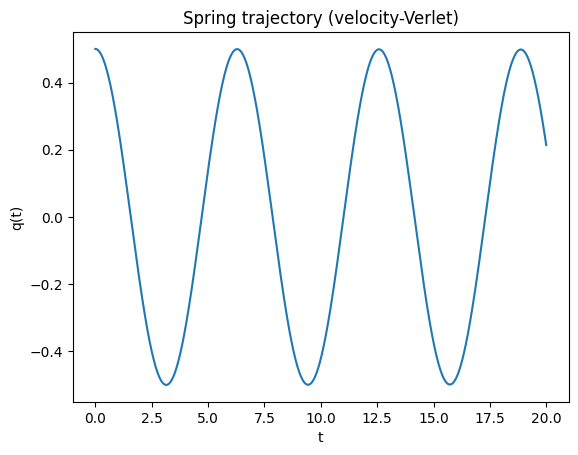

In [12]:
t0, tf, dt = 0.0, 20.0, 0.01
time = np.arange(t0, tf, dt)
trajectory = np.zeros((len(time), 2))

trajectory = np.zeros((len(time), 2))
trajectory[0] = [0.5, 0.0]

# get initial derivatives
dqdt, dpdt = derivatives(trajectory[0])   # dqdt = v, dpdt = m·a

for i in range(1, len(time)):
    q_n, p_n = trajectory[i-1]
    v_n = dqdt
    a_n = dpdt / m

    q_new = q_n + v_n*dt + 0.5*a_n*dt**2

    dqdt_new, dpdt_new = derivatives([q_new, p_n])
    a_new = dpdt_new / m

    v_new = v_n + 0.5*(a_n + a_new)*dt
    p_new = v_new * m

    trajectory[i] = [q_new, p_new]
    dqdt, dpdt = v_new, dpdt_new

# ----- plot q(t) -----
plt.figure()
plt.plot(time, trajectory[:, 0])
plt.xlabel('t')
plt.ylabel('q(t)')
plt.title('Spring trajectory (velocity-Verlet)')
plt.show()


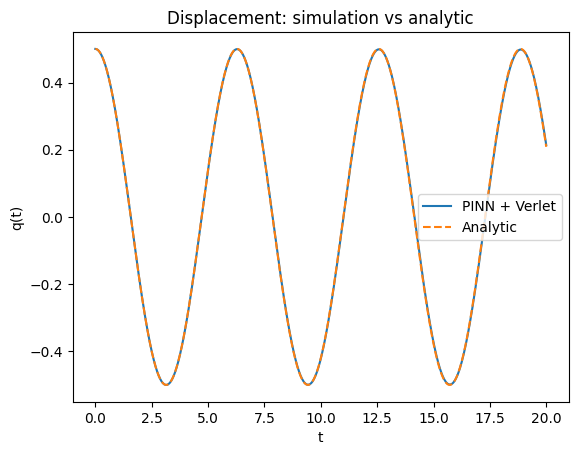

q RMSE: 2.704e-03


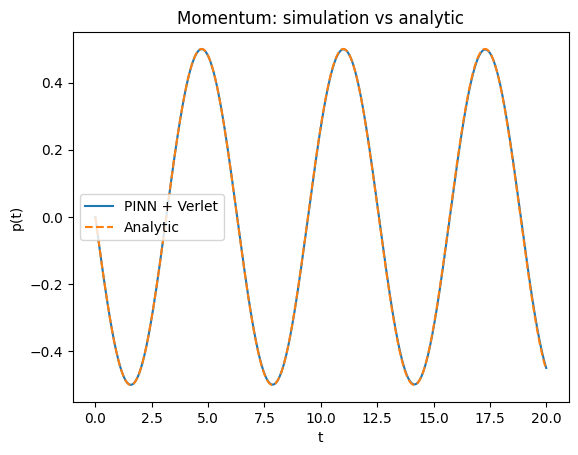

p RMSE: 2.913e-03


In [13]:
# compute analytic solution for damped oscillator
gamma = b/(2*m)
omega_d = np.sqrt(k/m - gamma**2)

q0 = trajectory[0][0]
# analytic displacement array
q_analytic = q0 * np.exp(-gamma*time) * np.cos(omega_d * time)

# analytic velocity and momentum arrays
dqdt_analytic = (
    -q0*gamma * np.exp(-gamma*time) * np.cos(omega_d*time)
    - q0*omega_d * np.exp(-gamma*time) * np.sin(omega_d*time)
)
p_analytic = m * dqdt_analytic

# plot comparison for q(t)
plt.figure()
plt.plot(time, trajectory[:, 0], label='PINN + Verlet')
plt.plot(time, q_analytic, '--', label='Analytic')
plt.xlabel('t')
plt.ylabel('q(t)')
plt.legend()
plt.title('Displacement: simulation vs analytic')
plt.show()

# compute and print RMSE for q
rmse_q = np.sqrt(np.mean((trajectory[:,0] - q_analytic)**2))
print(f"q RMSE: {rmse_q:.3e}")

# plot comparison for p(t)
plt.figure()
plt.plot(time, trajectory[:, 1], label='PINN + Verlet')
plt.plot(time, p_analytic, '--', label='Analytic')
plt.xlabel('t')
plt.ylabel('p(t)')
plt.legend()
plt.title('Momentum: simulation vs analytic')
plt.show()

# compute and print RMSE for p
rmse_p = np.sqrt(np.mean((trajectory[:,1] - p_analytic)**2))
print(f"p RMSE: {rmse_p:.3e}")
